# Solving the MountainCar problem

In this task we have a car, located at the bottom of a valley. The car can go to left or right with full throttle or do nothing.
Here the environment is a bit changed because the reward function is redefined to provide a dense feedback. In the original game -1 reward is received all the time. However this makes the convergence slow. 

To speed it up, the reward function will be:

$$r = \sin(p' \cdot 3) \cdot 0.45 + 0.55$$

where $p'$ is the position in the next state.

**State:** the $x$ coordinate of the car and the speed

**Action:** full throttle to left or right (left: 0, do nothing: 1 \[we will ignore this\], right: 2)

The solution will use the radial basis functions for feature extraction. You will implement Q-learning with a linear function approximator (based on the features) to train the Q-function.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym  # this library contains environments defined in advance

<img src="http://drive.google.com/uc?export=view&id=1XJj3Bju-mqZO8S9JT9QEfMAnZqAjj5X2" width=45%>

### Feature extraction

In [2]:
def init_weights(num_coarse):
    # num_coarse - how coarse is the feature space
    # the Q-function will be represented by a linear-approximator
    # initialize the weights matrix 
    # each weight correpsonds to a specific feature
    
    # ----- implement this single line -----
    return np.zeros((2, num_coarse, num_coarse))
    # create a numpy matrix with the appropriate size, now we have only two actions!


def center_points(num_coarse):
    # in case of the radial functions we need center points
    # the state space is 2D
    max_speed = 0.07
    min_speed = -0.07
    max_pos = 0.6
    min_pos = -1.2
    speeds = np.linspace(min_speed, max_speed, num_coarse)  
    positions = np.linspace(min_pos, max_pos, num_coarse)
    sigma = (max_pos - min_pos) / num_coarse
    ratio = (max_pos - min_pos) / (max_speed - min_speed)  # the scale of the speed and position is different, this would harm the exponential terms calculated from the speed, causing no effect of the speed
    return positions, speeds, sigma, ratio


def feature(state, centers):
    # calculate the feature values
    # take into account the ratio too
    pos, velocity = state  # position, velocity
    positions, speeds, sigma, ratio = centers
    # ----- implement the radial basis features according to the formula -----
    #-------------------------------------------------------------------#
    # the radial basis function tries to get values at each 'pos' and 'speed' of the vehicle
    f = np.zeros((len(positions), len(speeds))) 
    for i in range(len(positions)):
        for j in range(len(speeds)):
            p = (np.power((pos - positions[i]),2)) / (2 * np.power((sigma),2))             # getting position
            v = (np.power((velocity - speeds[j]),2)) / (2 * np.power((sigma/ratio) ,2))    # getting velocity
            f[j][i] = np.exp(-(p + v))                                                    # storing the exponential form
    
    return f  # the feature values in a numpy matrix

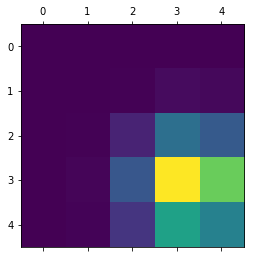

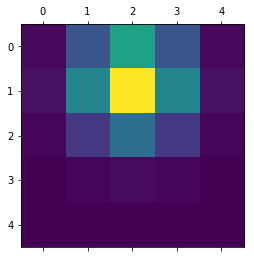

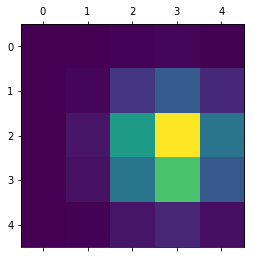

In [3]:
# testing the feature function
# this is a visualization to understand better the feature space
# the feature hashigh value at the location of the state in the state space
# the state space is spanned by the position and velocity of the car
# therefore the state space is 2-dimensional
cps = center_points(5)

state = (0.3, 0.04)
f = feature(state, cps)
plt.matshow(f)

state = (-0.3, -0.04)
f = feature(state, cps)
plt.matshow(f)

state = (0.1, 0.01)
f = feature(state, cps)
plt.matshow(f)

You should see for the first case:

<img src="http://drive.google.com/uc?export=view&id=1WyxbvdQm43yxuTRARRRpV5PtxwmF950G" width=45%>

### Saving/loading weights

In [4]:
# At the end we can save the weights.
# This is good for experimenting with the agent after training.

def save_weights(weights, file_path):
    np.save(file_path, weights, allow_pickle=False)


def load_weights(file_path):
    return np.load(file_path, allow_pickle=False)

### Functions for training

In [5]:
def Q_sa(state, action, weights, centers):
    # this is the Q-function
    # ----- implement this -----
    f = feature(state, centers)                       # calculate the features for the current state
    q_value = np.sum(np.multiply(weights[action], f)) # getting the q_values at each position and 
    return q_value                                    # calculate the Q-value from the weights, features and action (action: 0, 1)


def policy(state, weights, centers, epsilon):
    # epsilon-greedy for choosing the next action
    # return 0 for left, 2 for right (1 is ignored now)
    # ----- implement this -----

    # Checking for random_sample with epsilon
    if np.random.random_sample() < epsilon:
        action = np.random.choice([0,2])

    # Checking for q_value function
    else:
        left  = Q_sa(state, 0, weights, centers)
        right = Q_sa(state, 1, weights, centers)

        # getting values except 1
        if left < right:
            action = 2
        else:
            action = 0
    
    return action  # the sampled action


def update(state, action, r, state_next, weights, centers, gamma, alpha):
    # Q-learning update rule for the linear approximation
    # ----- implement this -----
    q = max(Q_sa(state_next, 0, weights, centers),
            Q_sa(state_next, 1, weights, centers))  # choose the best Q-value
    f =  feature(state, centers)                    # one-step return
    u = r + (gamma * q)
    action = action // 2                            # action can be 0 or 2 but 2 is not a valid index
    q_value = Q_sa(state, action, weights, centers)
    weights[action] +=  (alpha * (u - q_value)) * f # update the weights

### Training the agent

In [6]:
def train():
    # init the environment
    env = gym.make('MountainCar-v0')
    # set the seeds to make the results easier to reproduce
    np.random.seed(0)
    env.seed(1)
    
    # hyper-parameters (you can play with this parameters)
    num_iter = 5000
    num_coarse = 10
    epsilon = 1
    alpha = 0.35  # learning rate
    gamma = 0.98
    
    weights = init_weights(num_coarse)
    centers = center_points(num_coarse)

    for counter in range(num_iter):
        state = env.reset()  # state - [position, velocity]
        done = False
        score = 0  # to see the return (for status log)
        length = 0  # the length of the current episode (for status log)
        max_pos = -1.2  # how much further moved the car in the right direction (for status log)
        while not done:
            length += 1
            action = policy(state, weights, centers, epsilon)  # ---- get the action in the current state -----
            state_next, _, done, _ = env.step(action)  # ----- make one step with the environment -----
            if state_next[0] > max_pos:
                max_pos = state_next[0]  # this will show whether the agent is getting closer to the flag
            reward = np.sin(state_next[0]*3)*0.45+0.55  # redefined reward to get more feedback
            update(state, action, reward, state_next, weights, centers, gamma, alpha)
            score += reward
            state = state_next
        epsilon = max(epsilon - 1.0/num_iter , 0.1)  # decrease the epsilon (exploration -> exploitation)
        if counter % 10 == 0:  # logging
            print("{} -> {} -> {} -> {}".format(counter, length,  score, max_pos))
    # saving the weights at the end
    save_weights(weights, "wgt.npy")

### Video for seeing what the agent is doing

In [7]:
def visualize(weights, num_coarse):
    env = gym.make('MountainCar-v0')
    centers = centers = center_points(num_coarse)
    for counter in range(10):
        done = False
        state = env.reset()  # state - [position, velocity]
        score = 0
        while not done:
            action = policy(state, weights, centers, 0.0)  # during test there is no need for exploration
            state, reward, done, _ = env.step(action)
            env.render()  # to show a window with the moving car
            score += reward
        print("At iteration {} the score: {}".format(counter, score))

In [8]:
# This will not work on colab but it can run on a common laptop
# No need for gpu and computationally not expensive
train()
weights = load_weights("wgt.npy")
num_coarse = 10
visualize(weights, num_coarse)

0 -> 200 -> 21.000435993909083 -> -0.395309398226094
10 -> 200 -> 23.123953293968732 -> -0.3698149481858178
20 -> 200 -> 21.343813789482166 -> -0.4117559154052991
30 -> 200 -> 29.08833845133904 -> -0.3062876652671599
40 -> 200 -> 25.348753049321026 -> -0.32832729585853127
50 -> 200 -> 21.99580115587551 -> -0.3925651699902365
60 -> 200 -> 20.942209443798895 -> -0.4170068708271383
70 -> 200 -> 27.864047449863452 -> -0.3134984430396426
80 -> 200 -> 22.81492015293848 -> -0.37396248728283543
90 -> 200 -> 21.474549792174603 -> -0.3982901729137306
100 -> 200 -> 23.425290362229024 -> -0.37745126585965333
110 -> 200 -> 23.34600236249062 -> -0.3142068034491533
120 -> 200 -> 23.94621961527598 -> -0.33354441496909104
130 -> 200 -> 22.701768965020804 -> -0.3501006923258047
140 -> 200 -> 22.20900329293182 -> -0.39952909279603144
150 -> 200 -> 28.74117817667987 -> -0.2675647530099524
160 -> 200 -> 27.21624579098939 -> -0.26195449607054316
170 -> 200 -> 22.963869441563258 -> -0.33757463339390176
180 -

### Video for seeing what the agent is doing

In [9]:
def visualize(weights, num_coarse):
    env = gym.make('MountainCar-v0')
    centers = centers = center_points(num_coarse)
    for counter in range(10):
        done = False
        state = env.reset()  # state - [position, velocity]
        score = 0
        while not done:
            action = policy(state, weights, centers, 0.0)  # during test there is no need for exploration
            state, reward, done, _ = env.step(action)
            env.render()  # to show a window with the moving car
            score += reward
        print("At iteration {} the score: {}".format(counter, score))

In [10]:
# This will not work on colab but it can run on a common laptop
# No need for gpu and computationally not expensive
weights = load_weights("wgt.npy")
num_coarse = 10
visualize(weights, num_coarse)

At iteration 0 the score: -183.0
At iteration 1 the score: -179.0
At iteration 2 the score: -186.0
At iteration 3 the score: -191.0
At iteration 4 the score: -191.0
At iteration 5 the score: -98.0
At iteration 6 the score: -200.0
At iteration 7 the score: -100.0
At iteration 8 the score: -168.0
At iteration 9 the score: -97.0
